# 프로젝트 : 주식 예측 

[야후파이낸스]<https://finance.yahoo.com/>




# 0. 모듈 준비하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

# 1. 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume   

- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

# 2. 각종 전처리 수행   
- 결측치 처리

In [3]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- 로그 변환

In [4]:
ts_log = np.log(ts)

# 3. 시계열 안정성 분석 

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

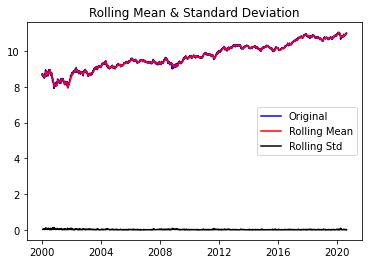

Results of Dickey-Fuller Test:
Test Statistic                   -0.679939
p-value                           0.851878
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


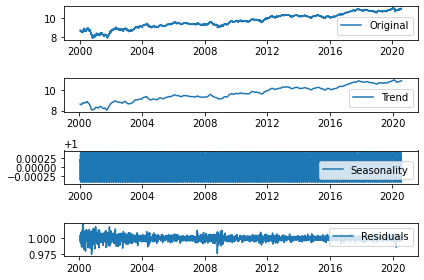

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Residual 안정성 확인   

p-value 가 매우 작으므로 이 자료는 stationary 하다고 볼 수 있다

In [8]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728530e+01
p-value                        5.748601e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


# 4. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

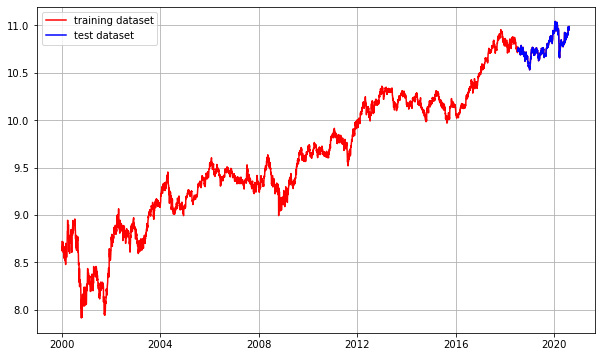

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5. 적정 ARIMA 모수 찾기 
- ACF, PACF 그려보기 -> p,q 구하기   
- 차분 안정성 확인    -> d 구하기

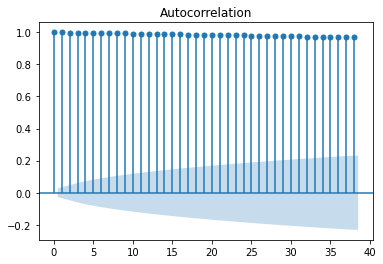

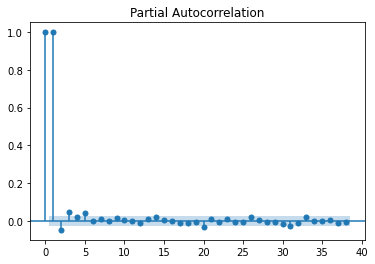

In [10]:
#p,q 구하기   p=1 , q=0
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.816723
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


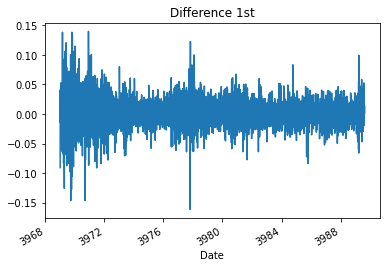

In [11]:
# 1차 차분 구하기  d=1
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [12]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp= -1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21960.569
Time:                        16:33:22   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


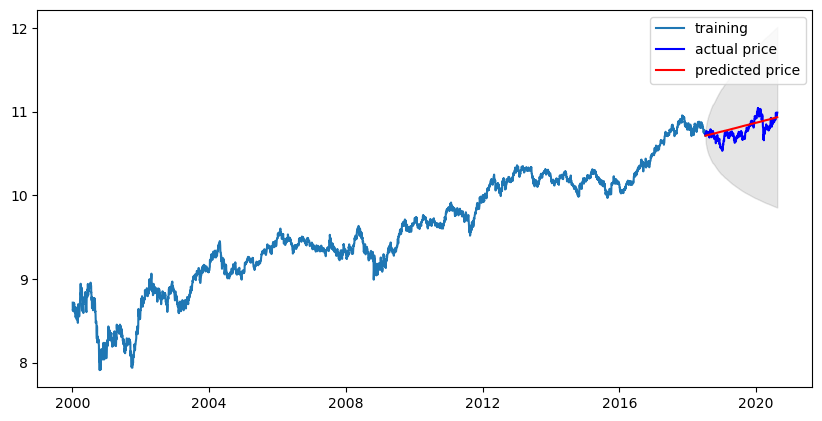

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18522409.431084756
MAE:  3590.960714790428
RMSE:  4303.766888562246
MAPE: 7.68%


#  구글 분석해보기

In [15]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [16]:
ts_log = np.log(ts)

In [17]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [18]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

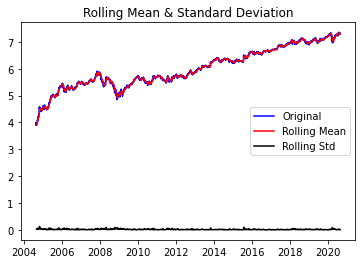

Results of Dickey-Fuller Test:
Test Statistic                   -2.296705
p-value                           0.173033
#Lags Used                       12.000000
Number of Observations Used    4011.000000
Critical Value (1%)              -3.431981
Critical Value (5%)              -2.862261
Critical Value (10%)             -2.567154
dtype: float64


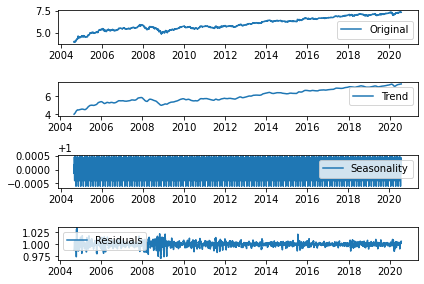

In [19]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [20]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.465120e+01
p-value                        3.498179e-27
#Lags Used                     3.000000e+01
Number of Observations Used    3.963000e+03
Critical Value (1%)           -3.432001e+00
Critical Value (5%)           -2.862270e+00
Critical Value (10%)          -2.567158e+00
dtype: float64


p-value가 충분히 작다!

In [21]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

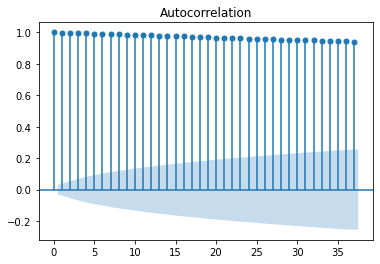

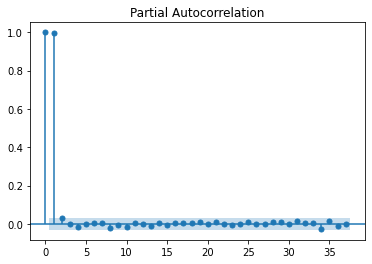

In [22]:
#p,q 구하기   p=1 , q=0
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.760902e+01
p-value                        3.887867e-30
#Lags Used                     1.100000e+01
Number of Observations Used    4.011000e+03
Critical Value (1%)           -3.431981e+00
Critical Value (5%)           -2.862261e+00
Critical Value (10%)          -2.567154e+00
dtype: float64


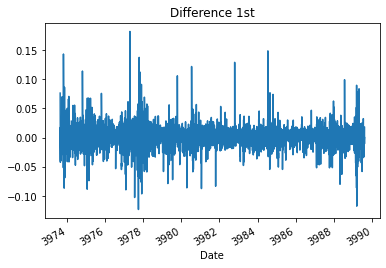

In [23]:
# 1차 차분 구하기  d=1
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [24]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp= -1)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [25]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7697.223371738794
MAE:  62.38887827130351
RMSE:  87.73382113950579
MAPE: 5.04%


삼성보다 구글의 MAPE값이 낮다!

# PEPSI 분석 

In [79]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/PEP.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [80]:
ts_log = np.log(ts)

In [81]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [82]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

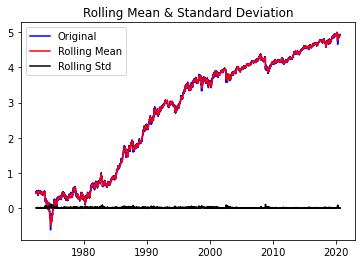

Results of Dickey-Fuller Test:
Test Statistic                    -0.592717
p-value                            0.872619
#Lags Used                         5.000000
Number of Observations Used    12150.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


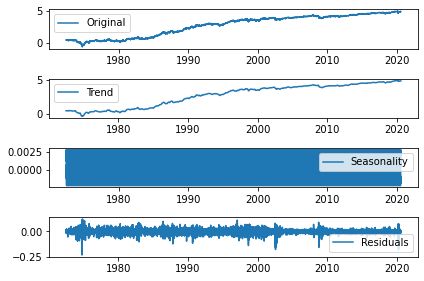

In [94]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [95]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                   -25.373904
p-value                            0.000000
#Lags Used                        38.000000
Number of Observations Used    12087.000000
Critical Value (1%)               -3.430891
Critical Value (5%)               -2.861779
Critical Value (10%)              -2.566897
dtype: float64


In [96]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

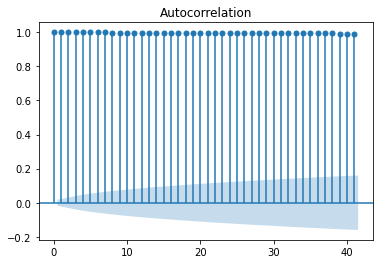

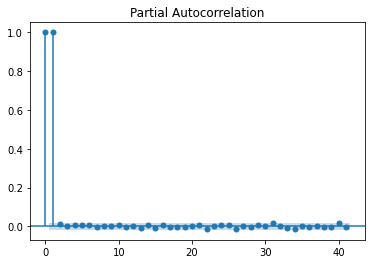

In [97]:
#p,q 구하기   p=1 , q=0
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -52.883673
p-value                            0.000000
#Lags Used                         4.000000
Number of Observations Used    12150.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


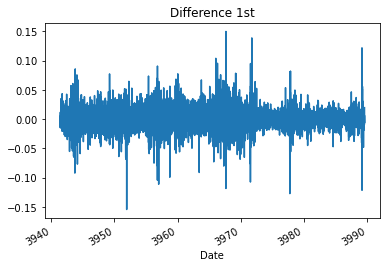

In [98]:
# 1차 차분 구하기  d=1
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                   -52.883673
p-value                            0.000000
#Lags Used                         4.000000
Number of Observations Used    12150.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


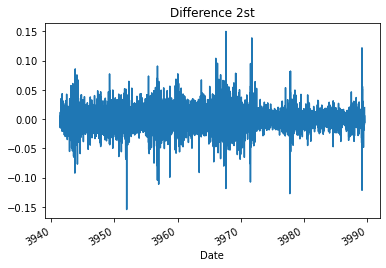

In [99]:
# 2차 차분 구하기  d=2
diff_2 = ts_log.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2st')

augmented_dickey_fuller_test(diff_2)

In [100]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp= -1)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [101]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  143.89008158712736
MAE:  8.95514503977855
RMSE:  11.995419191805151
MAPE: 7.71%


# 총평
- 삼성, 구글 그리고 펩시 같은 회사는 MAPE가 낮았다.   
- 그만큼 안정적인 그래프를 그리고 예측을 어느정도 할 수 있다고 볼 수 있다.   
- 하지만, 최근 상장된 기업이나 변동성이 큰 기업으로 했을 떄는 MPAE 값이 높게 나왔다.   
- 예측을 너무 믿으면 안된다.